# Topological regularization of Karate network embedding

In this notebook, we show how a topological loss can be combined with a graph embedding procedure, as to regularize the embedding and better reflect the topological---in this case disconnected---prior. 

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Tracking computation times
import time

# Handling arrays and data.frames
import pandas as pd 
import numpy as np

# Working with graphs in Python
import networkx as nx 

# Pytorch compatible topology layer and losses
import torch
from topologylayer.nn import AlphaLayer
from Code.losses import DiagramLoss, deepwalk_loss

# Random sampling for topological loss
import random

# Ordinary and topologically regularized graph embedding
from Code.topembed import DeepWalk

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Quantitative evaluation
from sklearn.svm import SVC
from Code.evaluation import evaluate_embeddings

%matplotlib inline

## Load and plot graph

We now load and plot the Karate network.

Number of nodes: 34


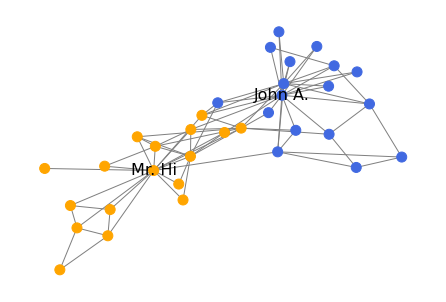

In [2]:
# Import the graph from the networkx library
G = nx.karate_club_graph()
print("Number of nodes: " + str(len(G.nodes())))

# Obtain the node grouping labels
node_labels = {0:"Mr. Hi", 33:"John A."}
node_color = ["Orange" if G.nodes()[n]["club"] == node_labels[0] else "royalblue" for n in G.nodes()]

# The graph imported from networkx is unweighted, we use a local file (without group labels) to assign the weights
adj = pd.read_csv(os.path.join("Data", "Karate.txt"), header=None, sep=" ")
for index, row in adj.iterrows():
    G[row[0]][row[1]]["weight"] = row[2]
del adj

# Plot the graph
G_layout = G.copy()
for u, v, d in G_layout.edges(data=True):
    d["weight"] = d["weight"] ** -1 # make larger weight edges shorter in the plot
layout = nx.spring_layout(G_layout, seed=17)
del G_layout
nx.draw(G, layout, node_color=node_color, labels=node_labels, font_size=16, node_size=100, edge_color="gray")

## Regular graph embedding

We first take a look at a regular embedding of this graph without topological regularization.

[epoch 1] [emb. loss: 2630.249512, top. loss: 0.000000, total loss: 2630.249512]
[epoch 5] [emb. loss: 2398.659180, top. loss: 0.000000, total loss: 2398.659180]
[epoch 10] [emb. loss: 2303.847168, top. loss: 0.000000, total loss: 2303.847168]
[epoch 15] [emb. loss: 2117.511475, top. loss: 0.000000, total loss: 2117.511475]
[epoch 20] [emb. loss: 2124.620850, top. loss: 0.000000, total loss: 2124.620850]
[epoch 25] [emb. loss: 2072.329590, top. loss: 0.000000, total loss: 2072.329590]
[epoch 30] [emb. loss: 2131.775879, top. loss: 0.000000, total loss: 2131.775879]
[epoch 35] [emb. loss: 2057.221191, top. loss: 0.000000, total loss: 2057.221191]
[epoch 40] [emb. loss: 2063.017090, top. loss: 0.000000, total loss: 2063.017090]
[epoch 45] [emb. loss: 1962.598877, top. loss: 0.000000, total loss: 1962.598877]
[epoch 50] [emb. loss: 2080.983398, top. loss: 0.000000, total loss: 2080.983398]
Time for embedding: 00:00:29


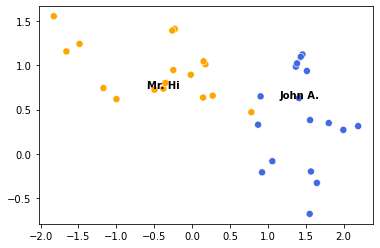

In [3]:
# Learning hyperparameters
num_epochs = 50
learning_rate = 1e-2

# Conduct graph embedding
model_emb = DeepWalk(G, num_epochs=num_epochs, learning_rate=learning_rate, random_state=42)
Y_emb = model_emb.phi.detach().numpy()

# View graph embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y_emb[:,0], y=Y_emb[:,1], s=50, c=node_color, ax=ax)
plt.text(Y_emb[0, 0], Y_emb[0, 1], "Mr. Hi", horizontalalignment="center", size="medium", weight="semibold")
plt.text(Y_emb[33, 0], Y_emb[33, 1], "John A.", horizontalalignment="center", size="medium", weight="semibold")
plt.show()

## Apply topological regularization to the embedding

We now show how we can bias a graph embedding using a loss function that captures our topological prior. As a topological loss, we will use the persistence of the second most prominent component in our embedding (one will always be infinite). It is important to multiply this by a factor $\lambda_{\mathrm{top}} <0$, since we want this persistence to be high. To obtain this loss, we require an additional layer that constructs the alpha complex from the embedding, from which subsequently persistent homology is computed.

In [4]:
# Define topological loss
def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
TopLayer = AlphaLayer(maxdim=1) # alpha complex layer
Component2Persistence = DiagramLoss(dim=0, i=2, j=2, g=g) # compute persistence of second most prominent gap
lambda_top = -5e1 # scalar factor that trades off embedding and topological loss
top_frac = .25 # sample fraction for which the topological loss is computed
sample_times = 10 # number of times we sample to approximate the expected topological loss value

# Construct topological loss function
def top_loss(output):
    loss = torch.tensor(0).type(torch.float)
    for _ in range(sample_times):
        sample = random.sample(range(output.shape[0]), int(output.shape[0] * top_frac))
        dgminfo = TopLayer(output[sample,:])
        loss += Component2Persistence(dgminfo)
    loss = lambda_top * loss / sample_times
    
    return loss

The topological loss is computed from a small sample in the embedding each time. This prevents the same point to be selected and moved away from the rest during each iteration, encouraging more natural communities, while simultaneously increasing computational efficiency.

We can now conduct the topologically regularized graph embedding as follows.

[epoch 1] [emb. loss: 2630.249512, top. loss: -22.328678, total loss: 2607.920898]
[epoch 5] [emb. loss: 2395.988281, top. loss: -31.885687, total loss: 2364.102539]
[epoch 10] [emb. loss: 2308.558594, top. loss: -43.800529, total loss: 2264.758057]
[epoch 15] [emb. loss: 2110.895020, top. loss: -59.299263, total loss: 2051.595703]
[epoch 20] [emb. loss: 2122.801270, top. loss: -76.591385, total loss: 2046.209839]
[epoch 25] [emb. loss: 2069.678711, top. loss: -89.287186, total loss: 1980.391479]
[epoch 30] [emb. loss: 2156.198730, top. loss: -102.294189, total loss: 2053.904541]
[epoch 35] [emb. loss: 2069.015137, top. loss: -106.906494, total loss: 1962.108643]
[epoch 40] [emb. loss: 2158.476074, top. loss: -108.399857, total loss: 2050.076172]
[epoch 45] [emb. loss: 2010.940430, top. loss: -109.103287, total loss: 1901.837158]
[epoch 50] [emb. loss: 2159.264893, top. loss: -112.310242, total loss: 2046.954590]
Time for embedding: 00:00:29


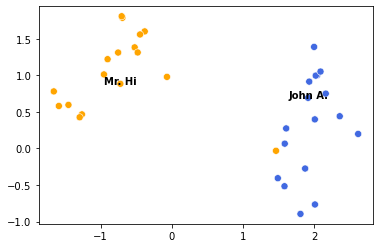

In [5]:
# Learning hyperparameters
num_epochs = 50
learning_rate = 1e-2

# Conduct topologically regularized graph embedding
model_top = DeepWalk(G, top_loss=top_loss, num_epochs=num_epochs, learning_rate=learning_rate, random_state=42)
Y_top = model_top.phi.detach().numpy()

# View topologically regularized graph embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y_top[:,0], y=Y_top[:,1], s=50, c=node_color, ax=ax)
plt.text(Y_top[0, 0], Y_top[0, 1], "Mr. Hi", horizontalalignment="center", size="medium", weight="semibold")
plt.text(Y_top[33, 0], Y_top[33, 1], "John A.", horizontalalignment="center", size="medium", weight="semibold")
plt.show()

## Compare with ordinary topological optimization

For comparison, we also conduct the same topological optimization procedure directly on the ordinary graph embedding.

[epoch 1] [emb. loss: 0.000000, top. loss: -59.893780, total loss: -59.893780]
[epoch 5] [emb. loss: 0.000000, top. loss: -137.522888, total loss: -137.522888]
[epoch 10] [emb. loss: 0.000000, top. loss: -238.692505, total loss: -238.692505]
[epoch 15] [emb. loss: 0.000000, top. loss: -345.417175, total loss: -345.417175]
[epoch 20] [emb. loss: 0.000000, top. loss: -513.678772, total loss: -513.678772]
[epoch 25] [emb. loss: 0.000000, top. loss: -642.297363, total loss: -642.297363]
[epoch 30] [emb. loss: 0.000000, top. loss: -800.632690, total loss: -800.632690]
[epoch 35] [emb. loss: 0.000000, top. loss: -861.788879, total loss: -861.788879]
[epoch 40] [emb. loss: 0.000000, top. loss: -865.923523, total loss: -865.923523]
[epoch 45] [emb. loss: 0.000000, top. loss: -1295.541382, total loss: -1295.541382]
[epoch 50] [emb. loss: 0.000000, top. loss: -1572.111328, total loss: -1572.111328]
Time for embedding: 00:00:01


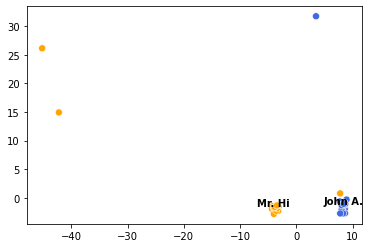

In [6]:
# Learning hyperparameters
num_epochs = 50
learning_rate = 1e-1

# Conduct topological optimization
model_opt = DeepWalk(G, emb_loss=False, top_loss=top_loss, init=Y_emb, num_epochs=num_epochs, 
                     learning_rate=learning_rate, random_state=42)
Y_opt = model_opt.phi.detach().numpy()

# View topologically optimized graph embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y_opt[:,0], y=Y_opt[:,1], s=50, c=node_color, ax=ax)
plt.text(Y_opt[0, 0], Y_opt[0, 1], "Mr. Hi", horizontalalignment="center", size="medium", weight="semibold")
plt.text(Y_opt[33, 0], Y_opt[33, 1], "John A.", horizontalalignment="center", size="medium", weight="semibold")
plt.show()

We observe that the graph embedding benefits most from combining both losses.

## Quantitative evaluation

First, we evaluate the different losses (embedding and topological) for all final embeddings.

In [7]:
emb_samples = 250 # number of samples for approximating (expected value of) the embedding loss
top_samples = 250 # number of samples for approximating (expected value of) topological loss
random.seed(42)
np.random.seed(42)

print("\033[1mLosses for graph embedding: \033[0m")
print("Embedding: " + str(np.mean([deepwalk_loss(model_emb, G, w=3, t=6).item() for _ in range(emb_samples)])))
print("Topological: " + str(np.mean([top_loss(torch.tensor(Y_emb).type(torch.float)) for _ in range(top_samples)]) 
                            / np.abs(lambda_top)) + "\n")

print("\033[1mLosses for topologically optimized graph embedding: \033[0m")
print("Embedding: " + str(np.mean([deepwalk_loss(model_opt, G, w=3, t=6).item() for _ in range(emb_samples)])))
print("Topological: " + str(np.mean([top_loss(torch.tensor(Y_opt).type(torch.float)) for _ in range(top_samples)]) 
                            / np.abs(lambda_top)) + "\n")

print("\033[1mLosses for topologically regularized graph embedding: \033[0m")
print("Embedding: " + str(np.mean([deepwalk_loss(model_top, G, w=3, t=6).item() for _ in range(emb_samples)])))
print("Topological: " + str(np.mean([top_loss(torch.tensor(Y_top).type(torch.float)) for _ in range(top_samples)]) 
                            / np.abs(lambda_top)))

Losses for graph embedding: 
Embedding: 2006.2999482421876
Topological: -1.316281280517578

Losses for topologically optimized graph embedding: 
Embedding: inf
Topological: -28.54066162109375

Losses for topologically regularized graph embedding: 
Embedding: 2111.991873046875
Topological: -2.3883558654785157


Finally, we compare if the topologically regularized embedding improves on the ordinary graph embedding for predicting data point labels.

In [13]:
# Machine learning model to be used for label prediction
Ys = {"emb": Y_emb, "top. opt.": Y_opt, "top. reg.": Y_top}
model = SVC()
scoring = "accuracy"

# Hyperparameters for quantitative evaluation
ntimes = 100
test_frac = 0.1
params = {"C":[0.01, 0.1, 1, 10, 100]}

# Obtain performances over multiple train-test splits
performances = evaluate_embeddings(Ys, node_color, model, scoring, params=params, stratify=node_color, 
                                   ntimes=ntimes, test_frac=test_frac, random_state=42)

# View resulting performances
pd.concat([pd.DataFrame({"mean":performances.mean(axis=0)}),
           pd.DataFrame({"std":performances.std(axis=0)})], axis=1)\
            .style.highlight_max(subset="mean", color="lightgreen", axis=0)

,mean,std
emb,0.972500,0.078617
top. opt.,0.912500,0.139330
top. reg.,0.972500,0.078617
